# Sankey diagram development

In [1]:
import os
os.getpid()

69724

In [2]:
import plotly.graph_objects as go
import btrack
import numpy as np
import json
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from macrohet import visualise, colours
import plotly.graph_objects as go
import matplotlib as mpl
from tqdm.auto import tqdm
# Set the default font to Helvetica
mpl.rcParams['font.family'] = 'Liberation Sans'

# Extracting single-cell 

In [3]:
df = pd.read_pickle('/mnt/SYNO/macrohet_syno/results/dfs/dt_df.pkl')

In [4]:
df = df[df['Strain'] != 'UNI']

In [5]:
df

index Acquisition ID  Biological Replicate  Cell ID Compound  \
0              0         (3, 4)                     1      426     CTRL   
1              1         (3, 4)                     1      426     CTRL   
2              2         (3, 4)                     1      426     CTRL   
3              3         (3, 4)                     1      426     CTRL   
4              4         (3, 4)                     1      426     CTRL   
...          ...            ...                   ...      ...      ...   
1315004  1797106        (6, 12)                     3     1874      BDQ   
1315005  1797107        (6, 12)                     3     1874      BDQ   
1315006  1797108        (6, 12)                     3     1874      BDQ   
1315007  1797109        (6, 12)                     3     1874      BDQ   
1315008  1797110        (6, 12)                     3     1874      BDQ   

        Concentration  Eccentricity Experiment ID  Final Infection Status  \
0                 EC0      0.929721        PS0000                     0.0   
1                 EC0      0.977788        PS0000                     0.0   
2                 EC0      0.733415        PS0000                     0.0   
3                 EC0      0.685354        PS0000                     0.0   
4                 EC0      0.727210        PS0000                     0.0   
...               ...           ...           ...                     ...   
1315004          EC99      0.571813        ND0003                     1.0   
1315005          EC99      0.373264        ND0003                     1.0   
1315006          EC99      0.490623        ND0003                     1.0   
1315007          EC99      0.693277        ND0003                     1.0   
1315008          EC99      0.752570        ND0003                     1.0   

         Frame  ...  Unique ID dMphi Area (µm)  dMtb Area (µm)   dt        r2  \
0          0.0  ...    426.3.4      -92.746118       -0.424621  7.0  0.944356   
1          1.0  ...    426.3.4      -92.746118       -0.424621  7.0  0.944356   
2          2.0  ...    426.3.4      -92.746118       -0.424621  7.0  0.944356   
3          3.0  ...    426.3.4      -92.746118       -0.424621  7.0  0.944356   
4          4.0  ...    426.3.4      -92.746118       -0.424621  7.0  0.944356   
...        ...  ...        ...             ...             ...  ...       ...   
1315004    NaN  ...  1874.6.12       55.088959        1.095075  NaN       NaN   
1315005    NaN  ...  1874.6.12       55.088959        1.095075  NaN       NaN   
1315006    NaN  ...  1874.6.12       55.088959        1.095075  NaN       NaN   
1315007    NaN  ...  1874.6.12       55.088959        1.095075  NaN       NaN   
1315008    NaN  ...  1874.6.12       55.088959        1.095075  NaN       NaN   

                  x           y              doubling_times  \
0        457.172943    8.791715  [2.0, 3.0, 4.0, 9.0, 17.0]   
1        459.138947    6.718642  [2.0, 3.0, 4.0, 9.0, 17.0]   
2        460.555237   10.785886  [2.0, 3.0, 4.0, 9.0, 17.0]   
3        455.878815   11.143067  [2.0, 3.0, 4.0, 9.0, 17.0]   
4        462.634186   14.050420  [2.0, 3.0, 4.0, 9.0, 17.0]   
...             ...         ...                         ...   
1315004  227.093262  130.358139                          []   
1315005  226.622925  130.532120                          []   
1315006  225.366608  129.932709                          []   
1315007  226.424683  128.489410                          []   
1315008  225.741119  126.533669                          []   

                            dmtb_values Strain/Compound  
0        [0.15, 0.31, 0.62, 1.23, 2.46]             RD1  
1        [0.15, 0.31, 0.62, 1.23, 2.46]             RD1  
2        [0.15, 0.31, 0.62, 1.23, 2.46]             RD1  
3        [0.15, 0.31, 0.62, 1.23, 2.46]             RD1  
4        [0.15, 0.31, 0.62, 1.23, 2.46]             RD1  
...                                 ...             ...  
1315004                              []          

In [6]:
# Get all unique combinations of compound and concentration
conditions = df[['Strain', 'Compound', 'Concentration']].drop_duplicates()

0it [00:00, ?it/s]

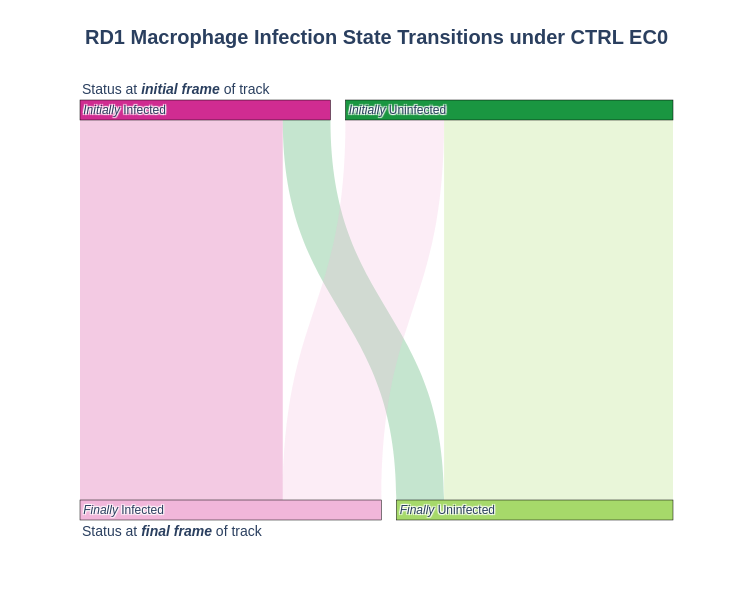

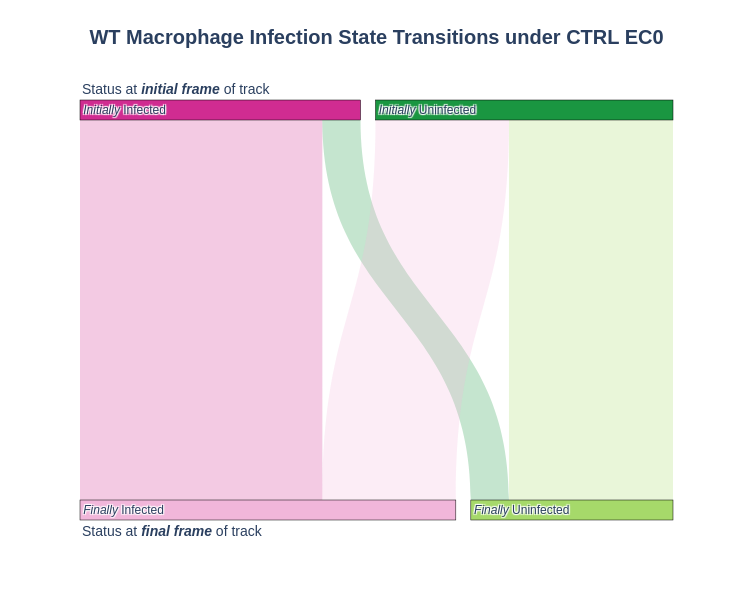

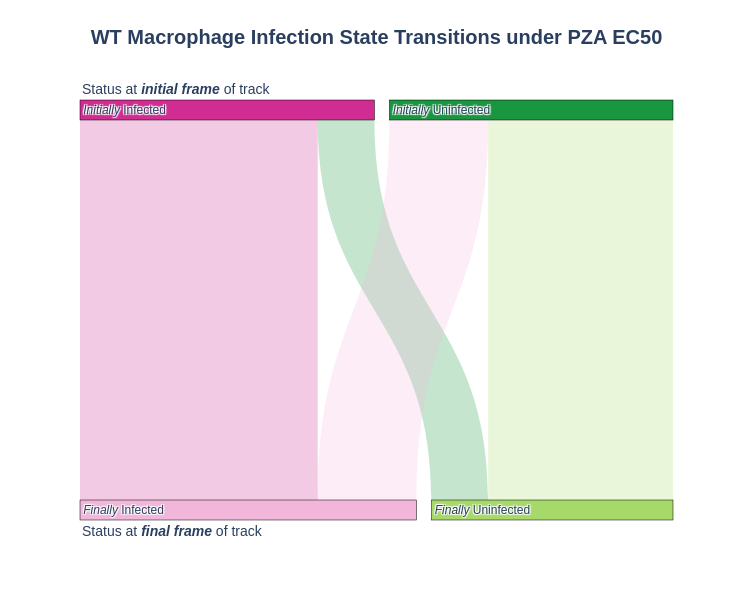

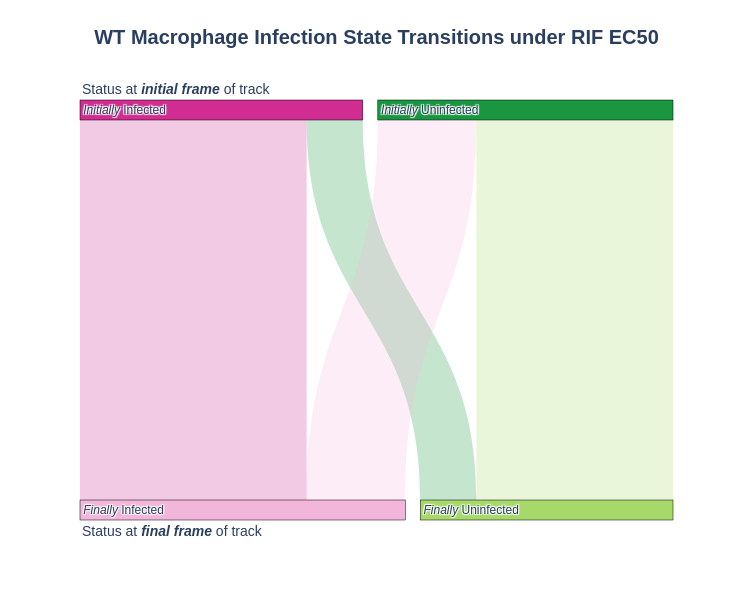

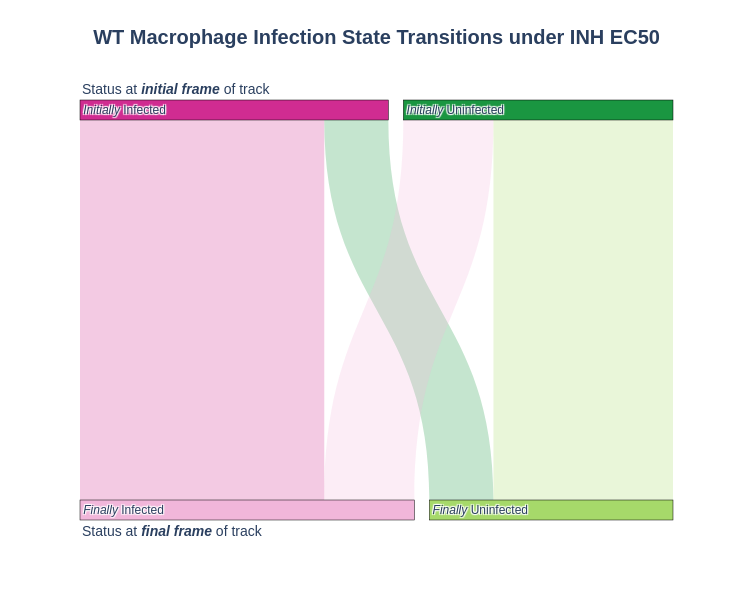

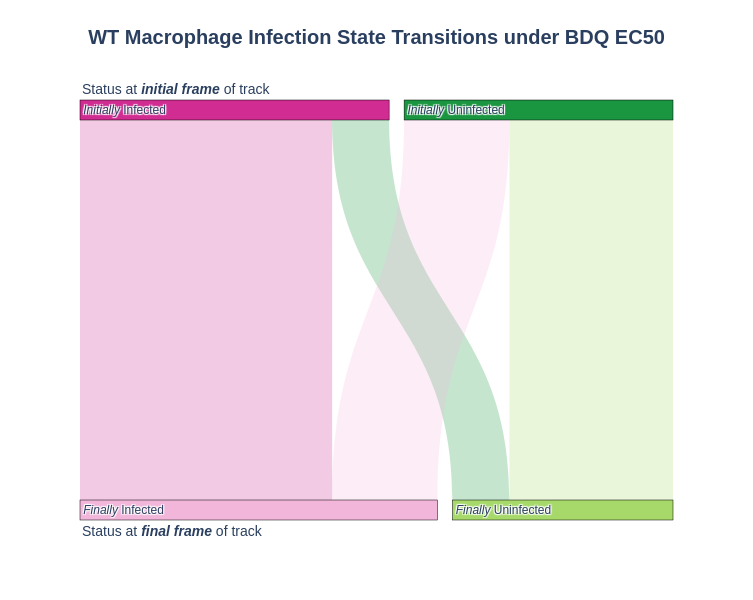

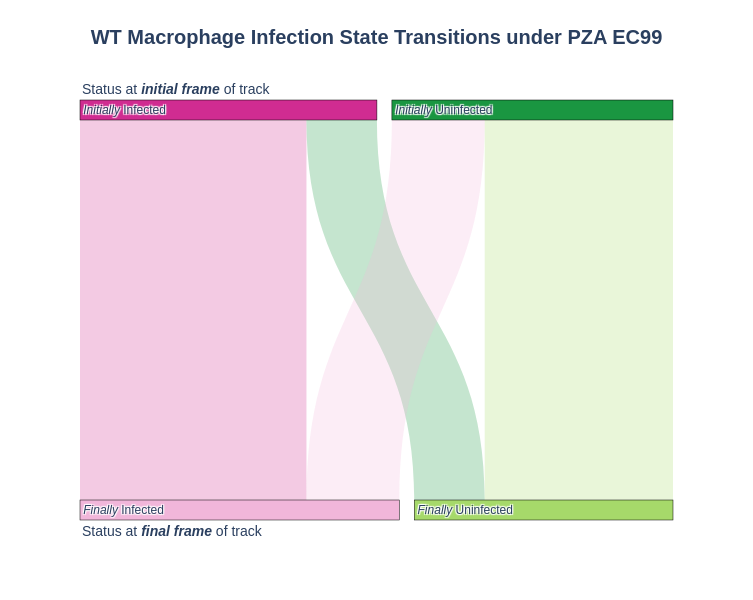

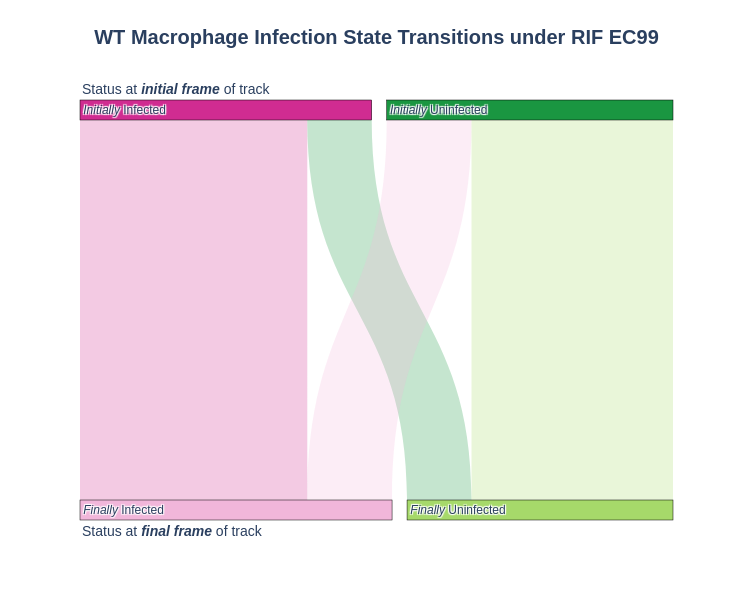

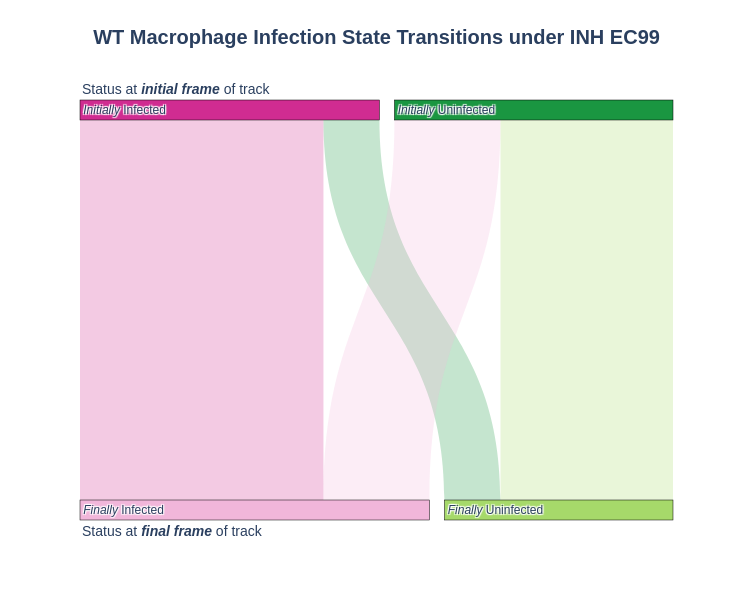

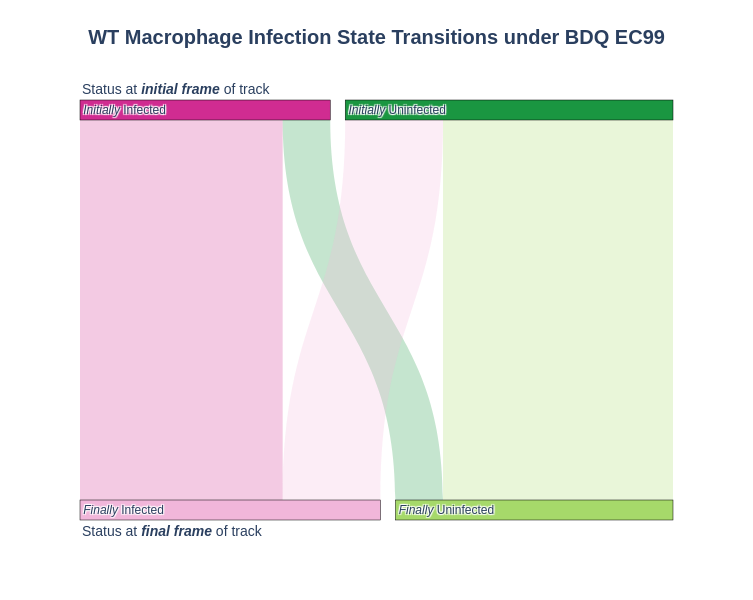

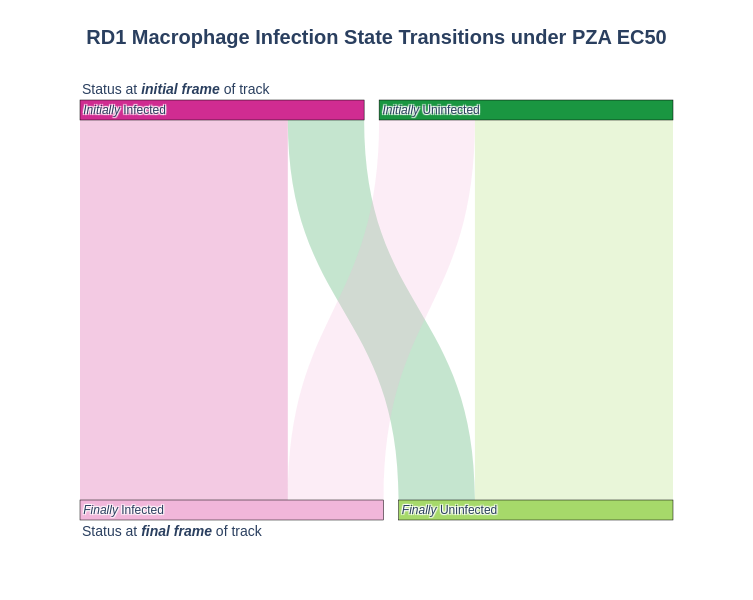

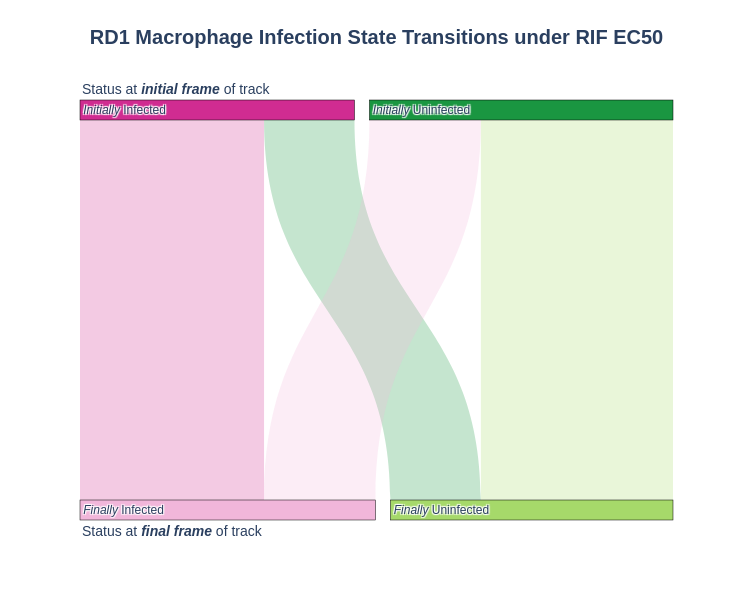

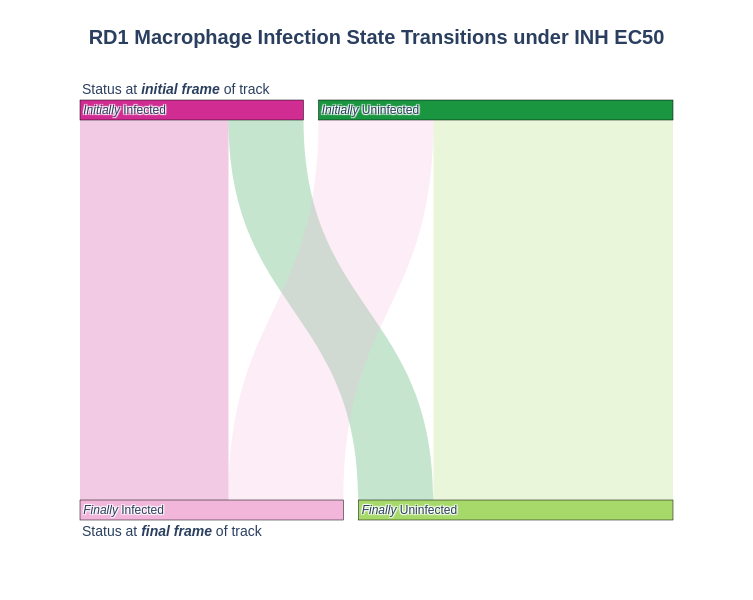

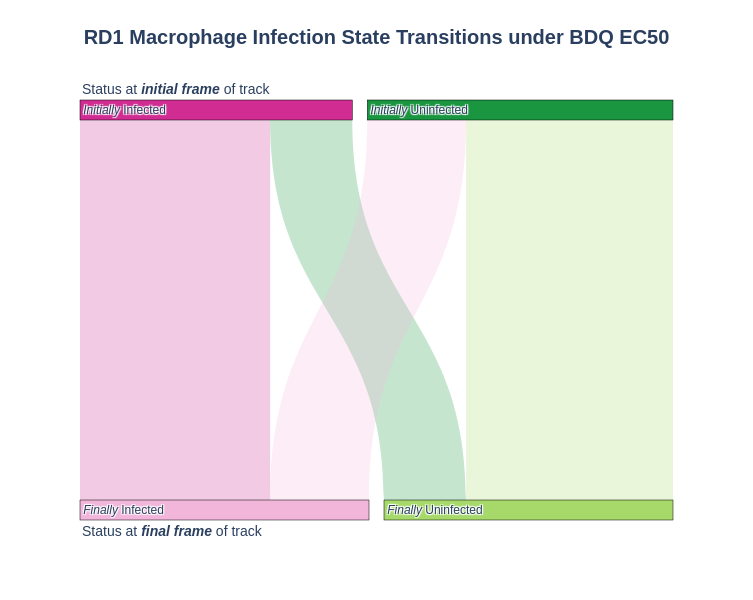

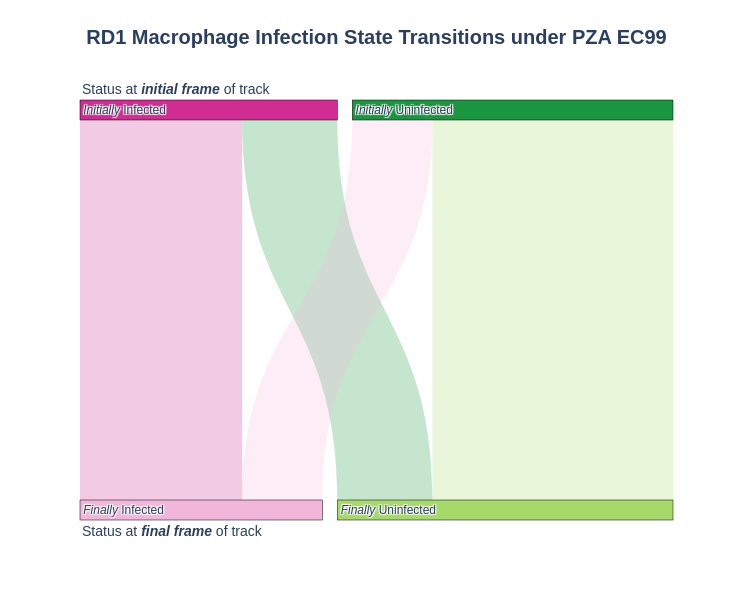

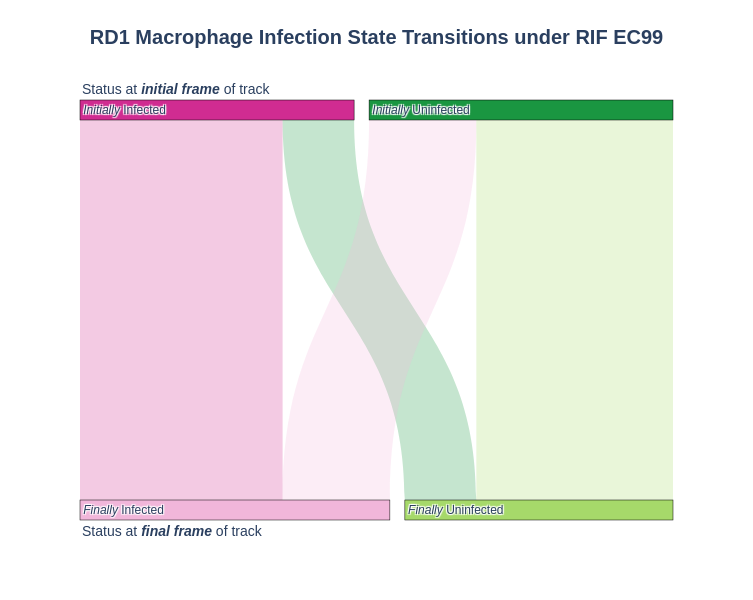

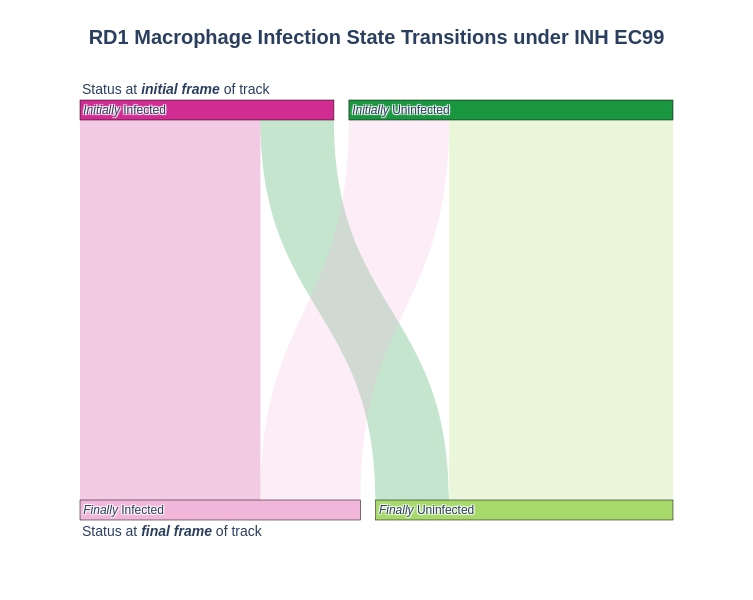

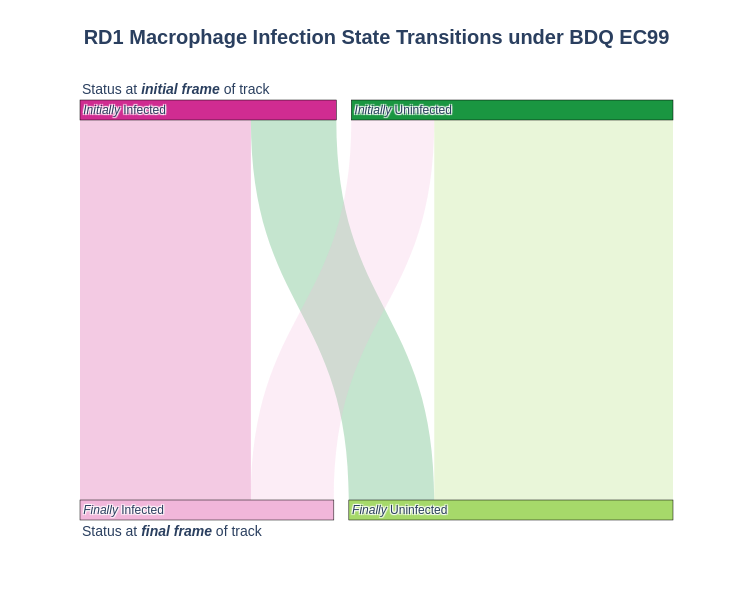

In [33]:

for i, condition in tqdm(conditions.iterrows()):

    strain = condition[0]
    compound = condition[1]
    concentration = condition[2]
    
    subset_df = df[(df['Strain'] == strain)
                 & (df['Compound'] == compound)
                 & (df['Concentration'] == concentration)
                 ]
    subset_df.drop_duplicates('ID', inplace=True)
    # Identify transitions
    transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()
    
    # Count the transitions
    N_stayed_infected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_got_uninfected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    N_got_infected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_stayed_uninfected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    
    # Define source, target, and value for Sankey diagram
    source = [0, 0, 1, 1]  # 0: Initially Infected, 1: Initially Uninfected
    target = [2, 3, 2, 3]  # 2: Finally Infected, 3: Finally Uninfected
    value = [
        N_stayed_infected,     # Initially Infected -> Finally Infected
        N_got_uninfected,      # Initially Infected -> Finally Uninfected
        N_got_infected,        # Initially Uninfected -> Finally Infected
        N_stayed_uninfected    # Initially Uninfected -> Finally Uninfected
    ]
    
    # Assuming colours.expanded_piyg is a list of hex colors
    link_colors = [f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)' for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1]]]
    
    # Define labels for nodes
    labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected"]
    node_colors =  [colours.expanded_piyg[i] for i in [-1,0, -2, 1]] #['blue', 'green', 'red', 'yellow']  # Example node colors
    
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        orientation = 'v',
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,        
            color=node_colors  # Set node colors
    
        ),
        link=dict(
            source=source,
            target=target,
            value=value, 
            color=link_colors
        ))])

    # Add annotations for the left and right edges
    annotations = [
        dict(
            x=0,  # x position of left label
            y=1.05,  # y position of left label (above the diagram)
            text="Status at <b><i>initial frame</i></b> of track",  # Text for the left label
            showarrow=False,
            font=dict(size=14)
        ),
        dict(
            x=0,  # x position of right label
            y=-0.05,  # y position of right label (above the diagram)
            text="Status at <b><i>final frame</i></b> of track",  # Text for the right label
            showarrow=False,
            font=dict(size=14)
        )
    ]

    
    fig.update_layout(
        title_text=f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
        # font_size=12,
        width=800,  # Set the width of the figure
        height=600,  # Set the height of the figure
        font_family="Liberation Sans", 
        annotations=annotations,
        title=dict(text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>", 
                   font=dict(size=20), x = 0.5, y =0.95)
    )
    
    fig.write_html(f"/mnt/SYNO/macrohet_syno/results/sankey/{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.html")
    fig.show()

## Ipywidgets interactive version

In [41]:
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import interact, Dropdown

# Sample dataframe setup
# df should include columns: 'Strain', 'Compound', 'Concentration', 'Initial Infection Status', 'Final Infection Status', 'ID'
# conditions should be a list or dataframe containing all unique combinations of 'Strain', 'Compound', 'Concentration'

# Function to create the Sankey diagram for a selected condition
def create_sankey(strain, compound, concentration):
    subset_df = df[(df['Strain'] == strain)
                   & (df['Compound'] == compound)
                   & (df['Concentration'] == concentration)]
    subset_df.drop_duplicates('ID', inplace=True)

    # Identify transitions
    transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()

    # Count the transitions
    N_stayed_infected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_got_uninfected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    N_got_infected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_stayed_uninfected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])

    # Define source, target, and value for Sankey diagram
    source = [0, 0, 1, 1]  # 0: Initially Infected, 1: Initially Uninfected
    target = [2, 3, 2, 3]  # 2: Finally Infected, 3: Finally Uninfected
    value = [
        N_stayed_infected,     # Initially Infected -> Finally Infected
        N_got_uninfected,      # Initially Infected -> Finally Uninfected
        N_got_infected,        # Initially Uninfected -> Finally Infected
        N_stayed_uninfected    # Initially Uninfected -> Finally Uninfected
    ]

    # Assuming colours.expanded_piyg is a list of hex colors
    link_colors = [f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)' for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1]]]

    # Define labels for nodes
    labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected"]
    node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1]]  # Example node colors

    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        orientation='v',
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors  # Set node colors
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors
        )
    )])

    # Add annotations for the left and right edges
    annotations = [
        dict(
            x=0,  # x position of left label
            y=1.05,  # y position of left label (above the diagram)
            text="Status at <b><i>initial frame</i></b> of track",  # Text for the left label
            showarrow=False,
            font=dict(size=14)
        ),
        dict(
            x=0,  # x position of right label
            y=-0.05,  # y position of right label (above the diagram)
            text="Status at <b><i>final frame</i></b> of track",  # Text for the right label
            showarrow=False,
            font=dict(size=14)
        )
    ]

    fig.update_layout(
        title=dict(
            text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>",
            font=dict(size=20),
            x=0.5,
            y=0.95
        ),
        width=800,  # Set the width of the figure
        height=600,  # Set the height of the figure
        font_family="Liberation Sans",
        annotations=annotations
    )

    fig.show()

# Extract unique values for dropdown menus
strains = df['Strain'].unique()
compounds = df['Compound'].unique()
concentrations = df['Concentration'].unique()

# Create interactive widgets
interact(create_sankey,
         strain=Dropdown(options=strains, description='Strain:'),
         compound=Dropdown(options=compounds, description='Compound:'),
         concentration=Dropdown(options=concentrations, description='Concentration:')
        )


interactive(children=(Dropdown(description='Strain:', options=('RD1', 'WT'), value='RD1'), Dropdown(descriptio…

<function __main__.create_sankey(strain, compound, concentration)>

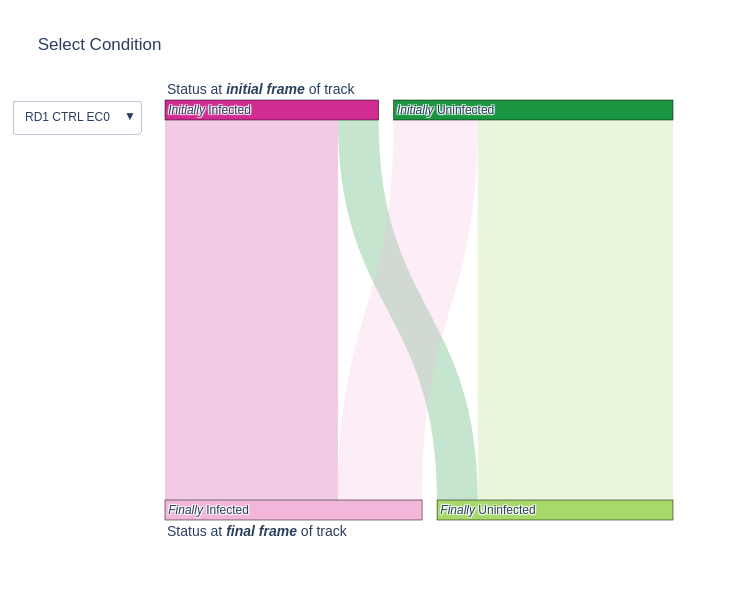

In [97]:
import pandas as pd
import plotly.graph_objects as go

# Sample dataframe setup
# df should include columns: 'Strain', 'Compound', 'Concentration', 'Initial Infection Status', 'Final Infection Status', 'ID'

# Extract unique values for dropdown menus
strains = df['Strain'].unique()
compounds = df['Compound'].unique()
concentrations = df['Concentration'].unique()

# Create the Sankey diagram function
def create_sankey_trace(strain, compound, concentration):
    subset_df = df[(df['Strain'] == strain)
                   & (df['Compound'] == compound)
                   & (df['Concentration'] == concentration)]
    subset_df.drop_duplicates('ID', inplace=True)

    # Identify transitions
    transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()

    # Count the transitions
    N_stayed_infected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_got_uninfected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    N_got_infected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_stayed_uninfected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])

    # Define source, target, and value for Sankey diagram
    source = [0, 0, 1, 1]  # 0: Initially Infected, 1: Initially Uninfected
    target = [2, 3, 2, 3]  # 2: Finally Infected, 3: Finally Uninfected
    value = [
        N_stayed_infected,     # Initially Infected -> Finally Infected
        N_got_uninfected,      # Initially Infected -> Finally Uninfected
        N_got_infected,        # Initially Uninfected -> Finally Infected
        N_stayed_uninfected    # Initially Uninfected -> Finally Uninfected
    ]

    # Assuming colours.expanded_piyg is a list of hex colors
    link_colors = [f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)' for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1]]]

    # Define labels for nodes
    labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected"]
    node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1]]  # Example node colors

    # Create the Sankey trace
    trace = go.Sankey(
        orientation='v',
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors  # Set node colors
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors
        ),
        visible=False  # Set initial visibility to False
    )
    return trace

conditions = df[['Strain', 'Compound', 'Concentration']].drop_duplicates().values
# Create initial traces for all combinations
traces = []
buttons = []
for idx, (strain, compound, concentration) in enumerate(conditions):
    trace = create_sankey_trace(strain, compound, concentration)
    traces.append(trace)
    buttons.append(dict(
        label=f"{strain} {compound} {concentration}",
        method="update",
        args=[{
                "visible": [False] * len(traces)
            }, {
                "title": f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
                "annotations": [
                    dict(
                        x=0,
                        y=1.05,
                        text="Status at <b><i>initial frame</i></b> of track",
                        showarrow=False,
                        font=dict(size=14)
                    ),
                    dict(
                        x=0,
                        y=-0.05,
                        text="Status at <b><i>final frame</i></b> of track",
                        showarrow=False,
                        font=dict(size=14)
                    )
                ]
            }]
    ))
    # Set visibility of the current trace to True
    buttons[-1]['args'][0]['visible'][idx] = True
    
# Create the initial figure
fig = go.Figure(data=traces)

# Make the first trace visible initially
fig.data[0].visible = True

# Create the dropdown menu
updatemenu = [dict(buttons=buttons, direction="down", showactive=True)]

# Update the layout to include the dropdown menu
fig.update_layout(
    updatemenus=updatemenu,
    title="Select Condition",
    annotations=[
        dict(
            x=0,
            y=1.05,
            text="Status at <b><i>initial frame</i></b> of track",
            showarrow=False,
            font=dict(size=14)
        ),
        dict(
            x=0,
            y=-0.05,
            text="Status at <b><i>final frame</i></b> of track",
            showarrow=False,
            font=dict(size=14)
        )
    ],
    width=800,
    height=600,
    font_family="Liberation Sans"
)

# Save as HTML
fig.write_html('/mnt/SYNO/macrohet_syno/results/sankey/WIP_interactive_sankey.html')

# Show the figure in Jupyter notebook (optional)
fig.show()


In [ ]:
fig.update_layout(
    updatemenus=[
        {
            'buttons': dropdown_strain,
            'direction': 'down',
            'showactive': True,
            'x': -0.15,
            'xanchor': 'left',
            'y': 0.9,
            'yanchor': 'top'
        },
        {
            'buttons': dropdown_compound,
            'direction': 'down',
            'showactive': True,
            'x': -0.15,
            'xanchor': 'left',
            'y': 0.8,
            'yanchor': 'top'
        },
        {
            'buttons': dropdown_concentration,
            'direction': 'down',
            'showactive': True,
            'x': -0.15,
            'xanchor': 'left',
            'y': 0.7,
            'yanchor': 'top'
        }
    ]
)


# Attempting to incorporate time into these diagrams

In [118]:
df['Duration (hours)'] = None

In [116]:
duration_tuple

(0.0, 73.0)

In [122]:
len(df[df['ID'] == ID])

74

In [124]:
[duration_tuple] * len(df[df['ID'] == ID])

[(0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0, 73.0),
 (0.0,

In [128]:

# Group by ID and calculate initial and final times
duration_df = df.groupby('ID')['Time (hours)'].agg(['first', 'last']).reset_index()
duration_df['Duration (hours)'] = list(zip(duration_df['first'], duration_df['last']))

# Drop the 'first' and 'last' columns as they are no longer needed
duration_df.drop(columns=['first', 'last'], inplace=True)

# Merge the duration data back to the original DataFrame
df = pd.merge(df, duration_df, on='ID')

In [133]:
# Rename columns if there are any conflicts after merge
df.rename(columns={'Duration (hours)_y': 'Duration (hours)'}, inplace=True)


In [142]:
subset_df = df[(df['Strain'] == strain)
               & (df['Compound'] == compound)
               & (df['Concentration'] == concentration)]
subset_df.drop_duplicates('ID', inplace=True)

# Extract initial and final time from the duration tuple
subset_df['Initial Time'] = subset_df['Duration (hours)'].apply(lambda x: x[0])
subset_df['Final Time'] = subset_df['Duration (hours)'].apply(lambda x: x[1])

# Normalize time to the range [0, 1]
max_time = subset_df['Final Time'].max()
subset_df['Initial Time Norm'] = subset_df['Initial Time'] / max_time
subset_df['Final Time Norm'] = subset_df['Final Time'] / max_time

transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status', 'Initial Time Norm', 'Final Time Norm'])['ID'].apply(list).reset_index()

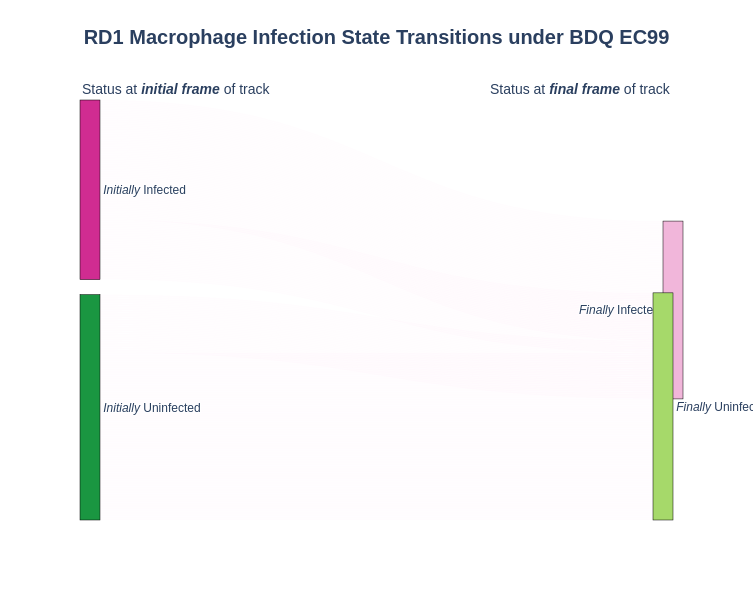

In [144]:

# Create the data for the Sankey diagram
source = []
target = []
value = []
link_colors = []

for _, row in transitions.iterrows():
    initial_status = row['Initial Infection Status']
    final_status = row['Final Infection Status']
    ids = row['ID']

    for id in ids:
        source.append(node_positions['Initially Infected'] if initial_status == 1 else node_positions['Initially Uninfected'])
        target.append(node_positions['Finally Infected'] if final_status == 1 else node_positions['Finally Uninfected'])
        value.append(1)  # Each individual line represents one transition
        link_colors.append(f'rgba({int(colours.expanded_piyg[-1][1:3], 16)}, {int(colours.expanded_piyg[-1][3:5], 16)}, {int(colours.expanded_piyg[-1][5:7], 16)}, 0.01)')

# Define labels for nodes
labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected"]
node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1]]

# Create nodes with fixed positions
nodes = [
    dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels[0], color=node_colors[0], x=0, y=0.5),
    dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels[1], color=node_colors[1], x=0, y=0),
    dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels[2], color=node_colors[2], x=1, y=0.5),
    dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels[3], color=node_colors[3], x=1, y=0)
]

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=[node['label'] for node in nodes],
        color=[node['color'] for node in nodes],
        x=[node['x'] for node in nodes],
        y=[node['y'] for node in nodes]
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
)])

# Add annotations for the left and right edges
annotations = [
    dict(
        x=0,  # x position of left label
        y=1.05,  # y position of left label (above the diagram)
        text="Status at <b><i>initial frame</i></b> of track",  # Text for the left label
        showarrow=False,
        font=dict(size=14)
    ),
    dict(
        x=1,  # x position of right label
        y=1.05,  # y position of right label (above the diagram)
        text="Status at <b><i>final frame</i></b> of track",  # Text for the right label
        showarrow=False,
        font=dict(size=14)
    )
]

fig.update_layout(
    title_text=f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
    width=800,  # Set the width of the figure
    height=600,  # Set the height of the figure
    font_family="Liberation Sans", 
    annotations=annotations,
    title=dict(text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>", 
               font=dict(size=20), x=0.5, y=0.95)
)

fig.write_html(f"/mnt/SYNO/macrohet_syno/results/sankey/{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.html")
fig.show()


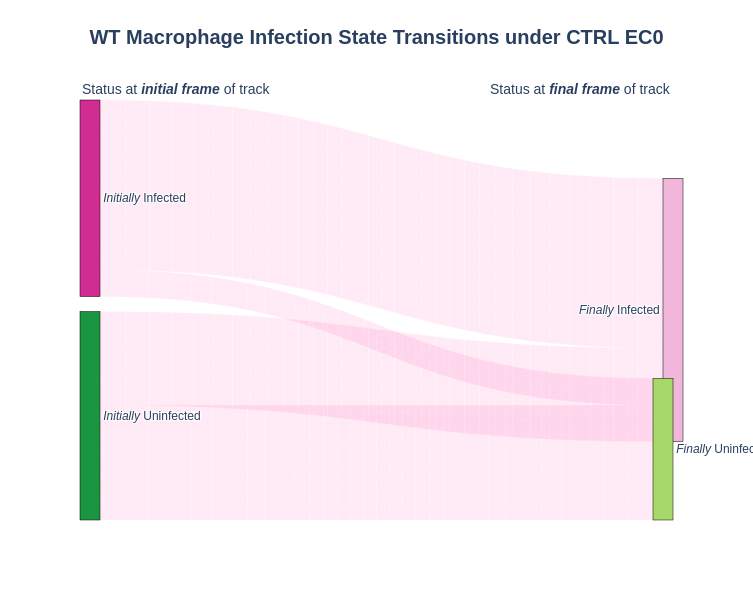

In [138]:
# Fix the position of nodes
node_positions = {
    'Initially Infected': 0,
    'Initially Uninfected': 1,
    'Finally Infected': 2,
    'Finally Uninfected': 3
}

# Create the Sankey diagram function
def create_sankey_with_duration(strain, compound, concentration):
    subset_df = df[(df['Strain'] == strain)
                   & (df['Compound'] == compound)
                   & (df['Concentration'] == concentration)]
    subset_df.drop_duplicates('ID', inplace=True)

    # Extract initial and final time from the duration tuple
    subset_df['Initial Time'] = subset_df['Duration (hours)'].apply(lambda x: x[0])
    subset_df['Final Time'] = subset_df['Duration (hours)'].apply(lambda x: x[1])

    # Normalize time to the range [0, 1]
    max_time = subset_df['Final Time'].max()
    subset_df['Initial Time Norm'] = subset_df['Initial Time'] / max_time
    subset_df['Final Time Norm'] = subset_df['Final Time'] / max_time

    # Identify transitions
    transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status', 'Initial Time Norm', 'Final Time Norm'])['ID'].apply(list).reset_index()

    # Create the data for the Sankey diagram
    source = []
    target = []
    value = []
    link_colors = []

    for _, row in transitions.iterrows():
        initial_status = row['Initial Infection Status']
        final_status = row['Final Infection Status']
        ids = row['ID']

        for id in ids:
            source.append(node_positions['Initially Infected'] if initial_status == 1 else node_positions['Initially Uninfected'])
            target.append(node_positions['Finally Infected'] if final_status == 1 else node_positions['Finally Uninfected'])
            value.append(1)  # Each individual line represents one transition
            link_colors.append(f'rgba({int(colours.expanded_piyg[-1][1:3], 16)}, {int(colours.expanded_piyg[-1][3:5], 16)}, {int(colours.expanded_piyg[-1][5:7], 16)}, 0.01)')

    # Define labels for nodes
    labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected"]
    node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1]]

    # Create nodes with fixed positions
    nodes = [
        dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels[0], color=node_colors[0], x=0, y=0.5),
        dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels[1], color=node_colors[1], x=0, y=0),
        dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels[2], color=node_colors[2], x=1, y=0.5),
        dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels[3], color=node_colors[3], x=1, y=0)
    ]

    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=[node['label'] for node in nodes],
            color=[node['color'] for node in nodes],
            x=[node['x'] for node in nodes],
            y=[node['y'] for node in nodes]
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors
        )
    )])

    # Add annotations for the left and right edges
    annotations = [
        dict(
            x=0,  # x position of left label
            y=1.05,  # y position of left label (above the diagram)
            text="Status at <b><i>initial frame</i></b> of track",  # Text for the left label
            showarrow=False,
            font=dict(size=14)
        ),
        dict(
            x=1,  # x position of right label
            y=1.05,  # y position of right label (above the diagram)
            text="Status at <b><i>final frame</i></b> of track",  # Text for the right label
            showarrow=False,
            font=dict(size=14)
        )
    ]

    fig.update_layout(
        title_text=f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
        width=800,  # Set the width of the figure
        height=600,  # Set the height of the figure
        font_family="Liberation Sans", 
        annotations=annotations,
        title=dict(text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>", 
                   font=dict(size=20), x=0.5, y=0.95)
    )

    fig.write_html(f"/mnt/SYNO/macrohet_syno/results/sankey/{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.html")
    fig.show()

# Example usage
create_sankey_with_duration('WT', 'CTRL', 'EC0')

In [23]:
manual_label_df['dt']

index Acquisition ID  Biological Replicate  Cell ID Compound  \
0    213686         (5, 9)                     1      394      BDQ   
1    214136         (5, 9)                     1      446      BDQ   
2    214811         (5, 9)                     1      369      BDQ   
3    215111         (5, 9)                     1      349      BDQ   
4    216081         (5, 9)                     1      469      BDQ   
5    216231         (5, 9)                     1      451      BDQ   
6    217652         (5, 9)                     1       37      BDQ   
7    218025         (5, 9)                     1      250      BDQ   
8    219298         (5, 9)                     1      187      BDQ   
9    284678         (6, 9)                     1      350      BDQ   
10   286246         (6, 9)                     1      519      BDQ   
11   286620         (6, 9)                     1      117      BDQ   
12   287295         (6, 9)                     1       24      BDQ   
13   287744         (6, 9)                     1        8      BDQ   
14   289459         (6, 9)                     1      180      BDQ   
15   903870        (4, 11)                     2      100      BDQ   
16   904093        (4, 11)                     2       90      BDQ   
17   904180        (4, 11)                     2      146      BDQ   
18   904330        (4, 11)                     2      137      BDQ   
19   908229        (4, 11)                     2      909      BDQ   
20   908494        (4, 11)                     2     1015      BDQ   
21   912477        (4, 12)                     2      343      BDQ   
22   913050        (4, 12)                     2      466      BDQ   
23   913401        (4, 12)                     2      508      BDQ   
24   914179        (4, 12)                     2      802      BDQ   
25   914501        (4, 12)                     2     1099      BDQ   
26  1469998        (4, 11)                     3      263      BDQ   
27  1470246        (4, 11)                     3      313      BDQ   
28  1471223        (4, 11)                     3      369      BDQ   
29  1474595        (4, 11)                     3      164      BDQ   
30  1477964        (4, 11)                     3     1132      BDQ   
31  1482031        (4, 11)                     3     1877      BDQ   
32  1483507        (4, 11)                     3     2038      BDQ   
33  1485512        (4, 11)                     3     2609      BDQ   
34  1486230        (4, 11)                     3     2882      BDQ   
35  1488231        (4, 12)                     3      270      BDQ   
36  1491505        (4, 12)                     3       84      BDQ   
37  1494516        (4, 12)                     3      364      BDQ   
38  1496465        (4, 12)                     3      816      BDQ   
39  1497631        (4, 12)                     3     1165      BDQ   
40  1498106        (4, 12)                     3     1367      BDQ   
41  1501455        (4, 12)                     3     1896      BDQ   
42  1502138        (4, 12)                     3     1954      BDQ   
43  1503652        (4, 12)                     3     2218      BDQ   
44  1506532        (4, 12)                     3     2671      BDQ   
45  1507222        (4, 12)                     3     2768      BDQ   

   Concentration  Eccentricity Experiment ID  Final Infection Status  Frame  \
0           EC99      0.747730        PS0000                     1.0    0.0   
1           EC99      0.847314        PS0000                     1.0    0.0   
2           EC99      0.668153        PS0000                     1.0    0.0   
3           EC99      0.230202        PS0000                     1.0    0.0   
4           EC99      0.572613        PS0000                     1.0    0.0   
5           EC99      0.676587        PS0000                     1.0    0.0   
6           EC99      0.840722        PS0000                     1.0    0.0   
7           EC99      0.716911        PS0000                     0.0    0.0   
8   

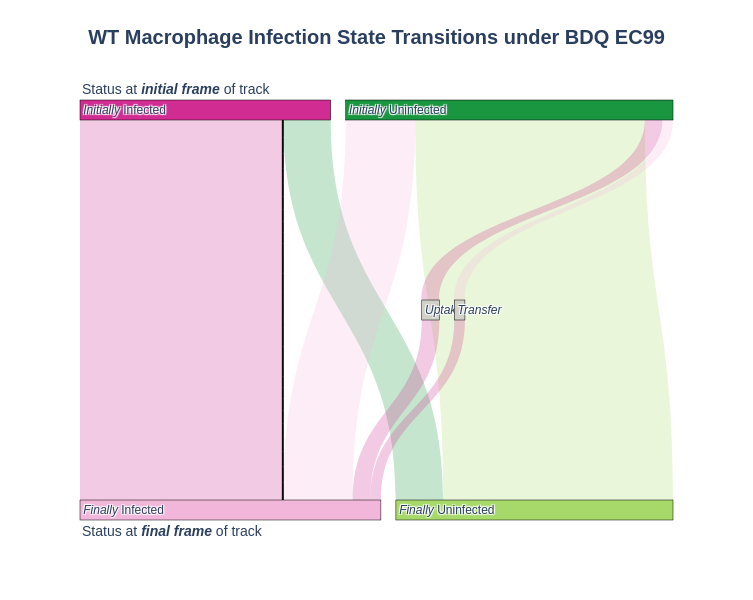

In [22]:
strain = 'WT' #condition[0]
compound = condition[1]
concentration = condition[2]

# Load manual labels
manual_label_fn = f'/mnt/SYNO/macrohet_syno/results/mtb_origin/{strain.lower()}_{compound}_{concentration}_init_uninf_updated_rapid_growers.csv'
    
manual_label_df = pd.read_csv(manual_label_fn)

subset_manual_label_df = manual_label_df[(manual_label_df['Strain'] == strain)
                                       & (manual_label_df['Compound'] == compound)
                                       & (manual_label_df['Concentration'] == concentration)
                                      ]

subset_df = df[(df['Strain'] == strain)
             & (df['Compound'] == compound)
             & (df['Concentration'] == concentration)
             ]
subset_df.drop_duplicates('ID', inplace=True)

# Identify transitions
transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()

# Count the transitions
N_stayed_infected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
N_got_uninfected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
N_got_infected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
N_stayed_uninfected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])

# Count the intermediate transitions
N_uptake = subset_manual_label_df['mtb_origin'].value_counts().get('Uptake', 0)
N_transfer = subset_manual_label_df['mtb_origin'].value_counts().get('Transfer', 0)
# Remove these manual observations from the original N_got_infected count
N_got_infected = N_got_infected - (N_uptake + N_transfer)

# Define source, target, and value for Sankey diagram
source = [0, 0, 1, 1, 1, 1, 4, 5, 0]  # Added sources for uptake and transfer
target = [2, 3, 2, 3, 4, 5, 2, 2, 2]  # Added targets for uptake and transfer
value = [
    N_stayed_infected,     # Initially Infected -> Finally Infected
    N_got_uninfected,      # Initially Infected -> Finally Uninfected
    N_got_infected,        # Initially Uninfected -> Finally Infected
    N_stayed_uninfected,   # Initially Uninfected -> Finally Uninfected
    N_uptake,              # Initially Uninfected -> Uptake
    N_transfer,            # Initially Uninfected -> Transfer
    N_uptake,              # Uptake -> Finally Infected
    N_transfer,   # Transfer -> Finally Infected
    1,
]

# Assuming colours.expanded_piyg is a list of hex colors
link_colors = [f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)' for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, -1, -2, -1, -1]]]

# Define labels for nodes
labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected", "<i>Uptake</i>", "<i>Transfer</i>"]
node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, 3, 3]]

# # Set fixed positions for nodes
# node_x = [0, 0.1, 0.9, 0.9, 0.3, 0.5]
# node_y = [1, 0.2, 0.8, 0.2, 0.6, 0.4]

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    orientation='v',
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors,  # Set node colors
        # x=node_x,
        # y=node_y
    ),
    link=dict(
        
        source=source,
        target=target,
        value=value,
        color=link_colors, 
        
    ))])

# Add annotations for the left and right edges
annotations = [
    dict(
        x=0,  # x position of left label
        y=1.05,  # y position of left label (above the diagram)
        text="Status at <b><i>initial frame</i></b> of track",  # Text for the left label
        showarrow=False,
        font=dict(size=14)
    ),
    dict(
        x=0,  # x position of right label
        y=-0.05,  # y position of right label (above the diagram)
        text="Status at <b><i>final frame</i></b> of track",  # Text for the right label
        showarrow=False,
        font=dict(size=14)
    )
]

fig.update_layout(
    title_text=f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
    # font_size=12,
    width=800,  # Set the width of the figure
    height=600,  # Set the height of the figure
    font_family="Liberation Sans", 
    annotations=annotations,
    title=dict(text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>", 
               font=dict(size=20), x=0.5, y=0.95)
)
fig.show()

# Interactive 

In [43]:
min_dt = 0
max_dt = 100

# Load manual labels
manual_label_fn = f'/mnt/SYNO/macrohet_syno/results/mtb_origin/{strain.lower()}_{compound}_{concentration}_init_uninf_updated_rapid_growers.csv'
manual_label_df = pd.read_csv(manual_label_fn)

# Load subset of the dataframe (assuming df is predefined)
subset_df = df[(df['Strain'] == strain)
             & (df['Compound'] == compound)
             & (df['Concentration'] == concentration)]
subset_df.drop_duplicates('ID', inplace=True)

# Filter numeric 'dt' values and remove NaNs
subset_df = subset_df[subset_df['dt'] > min_time] 
numeric_dt_values = subset_df['dt'].dropna().unique()
numeric_dt_values = [dt for dt in numeric_dt_values if pd.api.types.is_numeric_dtype(type(dt))]

# Initialize the Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.RangeSlider(
        id='dt-slider',
        min=min(numeric_dt_values),
        max=max(numeric_dt_values),
        value=[min(numeric_dt_values), max(numeric_dt_values)],
        marks={int(dt): str(int(dt)) for dt in numeric_dt_values},
        step=2
    ),
    dcc.Graph(id='sankey-graph')
])

# Modify the callback function to handle the range of values
@app.callback(
    Output('sankey-graph', 'figure'),
    Input('dt-slider', 'value')
)
def update_sankey(selected_dt_range):
    min_dt, max_dt = selected_dt_range

    subset_manual_label_df = manual_label_df[(manual_label_df['Strain'] == strain)
                                           & (manual_label_df['Compound'] == compound)
                                           & (manual_label_df['Concentration'] == concentration)
                                           & (manual_label_df['dt'] >= min_dt)
                                           & (manual_label_df['dt'] <= max_dt)]

    subset_df_filtered = subset_df[(subset_df['dt'] >= min_dt) & (subset_df['dt'] <= max_dt)]

    transitions = subset_df_filtered.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()
    N_stayed_infected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_got_uninfected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    N_got_infected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_stayed_uninfected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    
    N_uptake = subset_manual_label_df['mtb_origin'].value_counts().get('Uptake', 0)
    N_transfer = subset_manual_label_df['mtb_origin'].value_counts().get('Transfer', 0)
    N_got_infected = N_got_infected - (N_uptake + N_transfer)

    source = [0, 0, 1, 1, 1, 1, 4, 5, ]
    target = [2, 3, 2, 3, 4, 5, 2, 2, ]
    value = [
        N_stayed_infected, N_got_uninfected, N_got_infected, N_stayed_uninfected,
        N_uptake, N_transfer, N_uptake, N_transfer, 
    ]

    labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected", "<i>Uptake</i>", "<i>Transfer</i>"]
    node_colors = ['#d02c91', '#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da']
    link_colors = [f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)' for color in node_colors]

    fig = go.Figure(data=[go.Sankey(
        orientation='v',
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors
        )
    )])

    annotations = [
        dict(x=0, y=1.05, text="Status at <b><i>initial frame</i></b> of track", showarrow=False, font=dict(size=14)),
        dict(x=0, y=-0.05, text="Status at <b><i>final frame</i></b> of track", showarrow=False, font=dict(size=14))
    ]

    fig.update_layout(
        title_text=f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
        width=800, height=600, font_family="Liberation Sans",
        annotations=annotations,
        title=dict(text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>", font=dict(size=20), x=0.5, y=0.95)
    )
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)

---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
IndexError: index 0 is out of bounds for axis 0 with size 0

---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
IndexError: index 0 is out of bounds for axis 0 with size 0



In [34]:
len(value)

9

# if the track doesnt exist at the final frame of the movie, then is that cell dead? 

add labels that show beginning of movie / end of movie 

incorporate actual fate from the manual identification

# Incorporate manual labels in 

In [168]:
conditions

array([['RD1', 'CTRL', 'EC0'],
       ['WT', 'CTRL', 'EC0'],
       ['WT', 'PZA', 'EC50'],
       ['WT', 'RIF', 'EC50'],
       ['WT', 'INH', 'EC50'],
       ['WT', 'BDQ', 'EC50'],
       ['WT', 'PZA', 'EC99'],
       ['WT', 'RIF', 'EC99'],
       ['WT', 'INH', 'EC99'],
       ['WT', 'BDQ', 'EC99'],
       ['RD1', 'PZA', 'EC50'],
       ['RD1', 'RIF', 'EC50'],
       ['RD1', 'INH', 'EC50'],
       ['RD1', 'BDQ', 'EC50'],
       ['RD1', 'PZA', 'EC99'],
       ['RD1', 'RIF', 'EC99'],
       ['RD1', 'INH', 'EC99'],
       ['RD1', 'BDQ', 'EC99']], dtype=object)

0it [00:00, ?it/s]

No manual labels for ('RD1', 'CTRL', 'EC0')


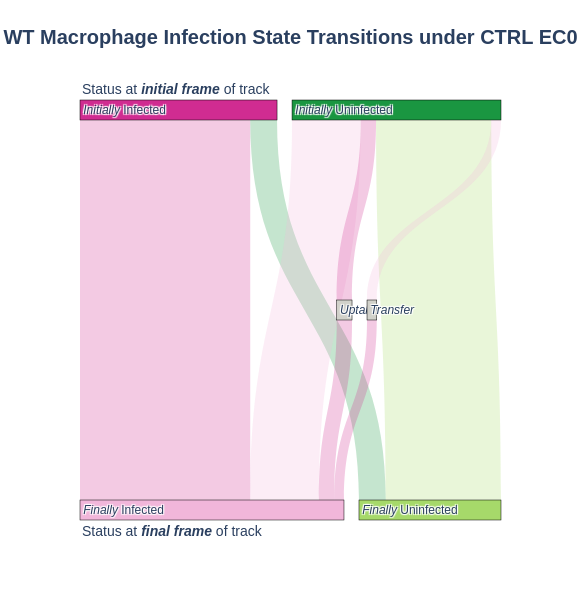

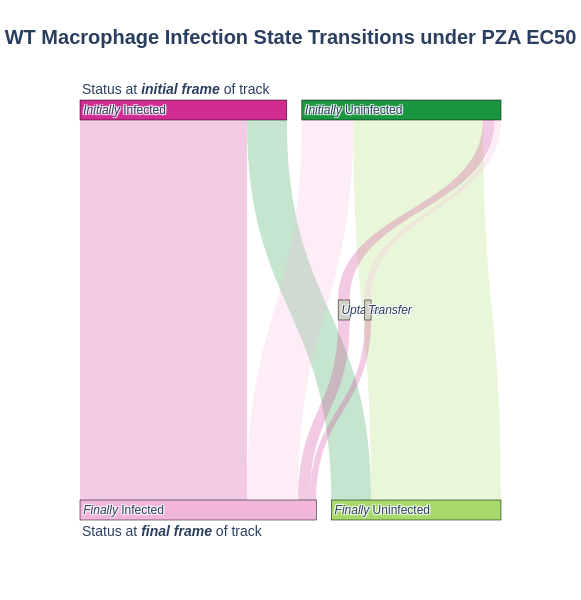

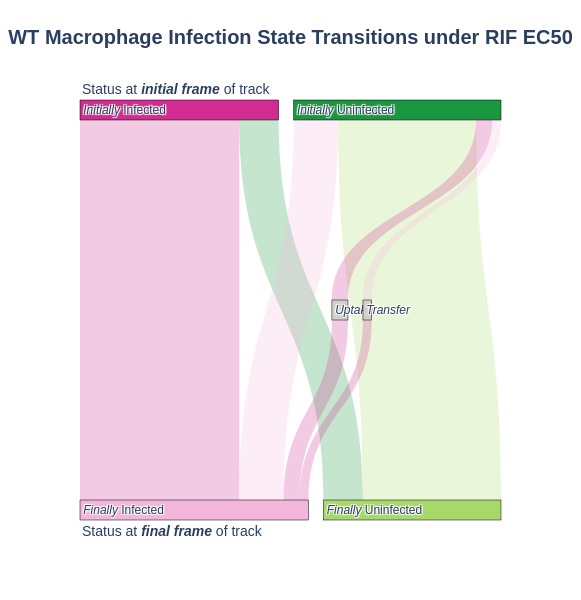

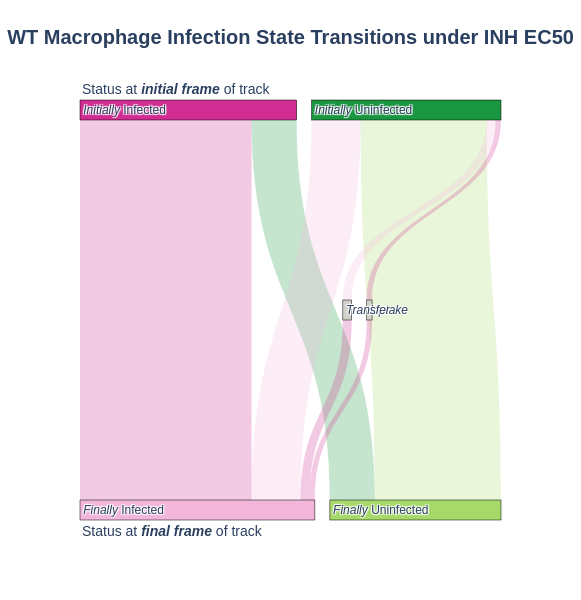

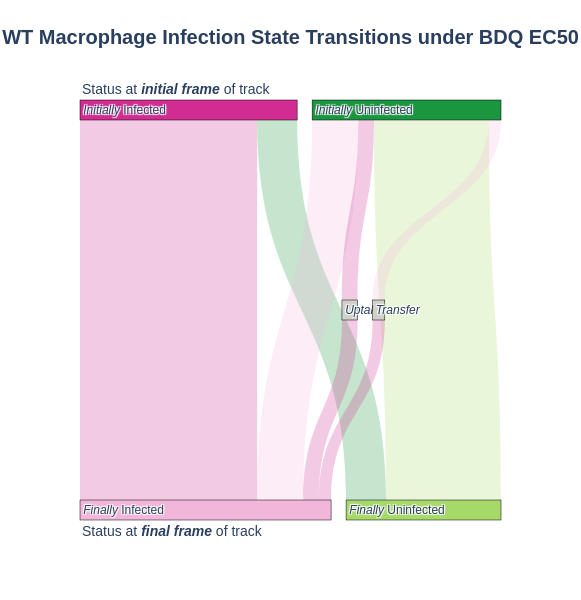

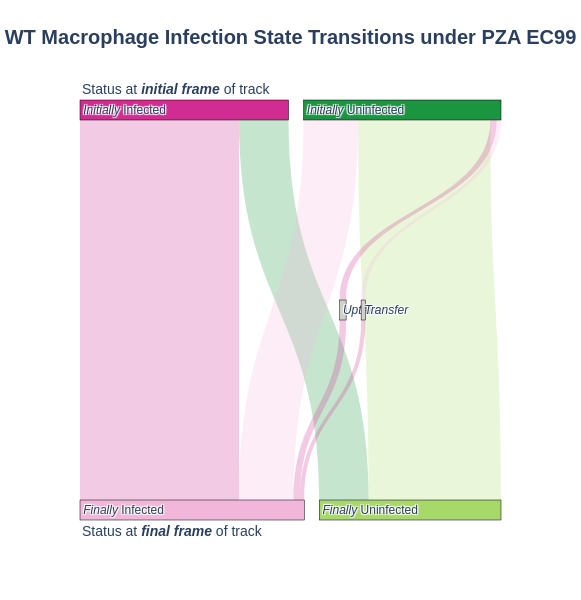

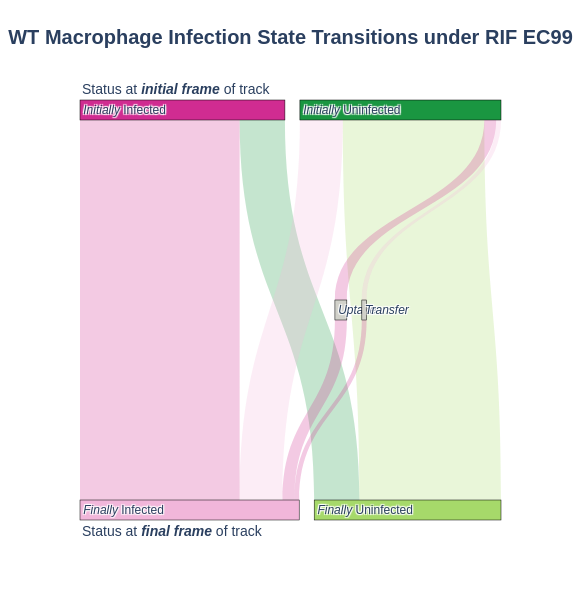

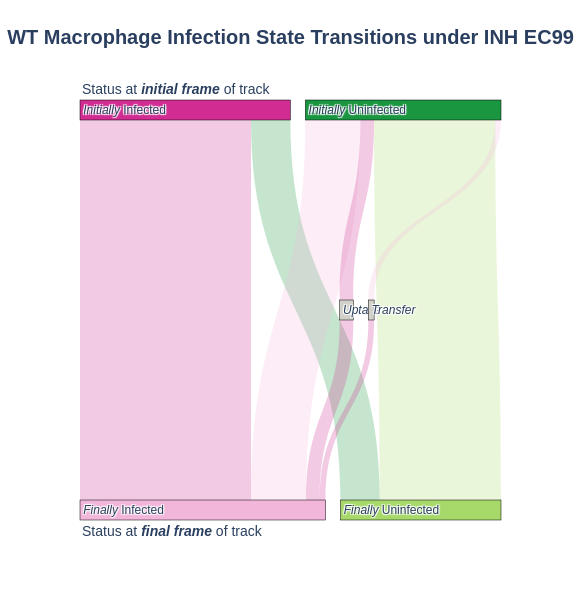

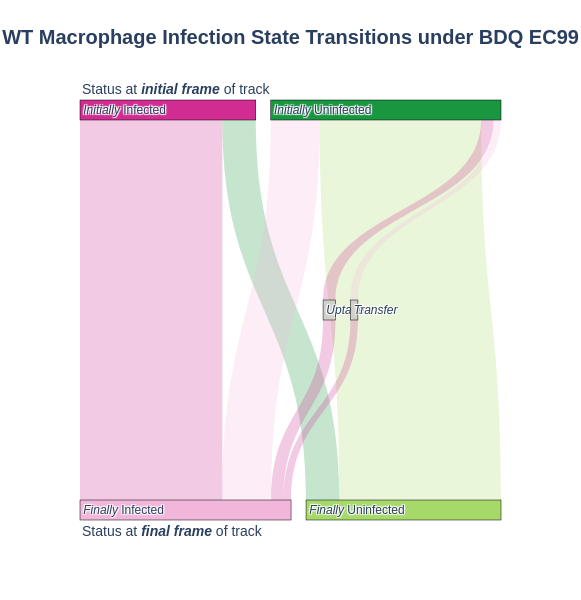

No manual labels for ('RD1', 'PZA', 'EC50')
No manual labels for ('RD1', 'RIF', 'EC50')
No manual labels for ('RD1', 'INH', 'EC50')
No manual labels for ('RD1', 'BDQ', 'EC50')
No manual labels for ('RD1', 'PZA', 'EC99')
No manual labels for ('RD1', 'RIF', 'EC99')
No manual labels for ('RD1', 'INH', 'EC99')
No manual labels for ('RD1', 'BDQ', 'EC99')


In [10]:
# Get all unique combinations of strain, compound, and concentration
conditions = df[['Strain', 'Compound', 'Concentration']].drop_duplicates()

for i, condition in tqdm(conditions.iterrows()):

    strain = condition[0]
    compound = condition[1]
    concentration = condition[2]

    # Load manual labels
    manual_label_fn = f'/mnt/SYNO/macrohet_syno/results/mtb_origin/{strain.lower()}_{compound}_{concentration}_init_uninf_updated_rapid_growers.csv'
    
    if not os.path.exists(manual_label_fn):
        print(f'No manual labels for {strain, compound, concentration}')
        continue
        
    manual_label_df = pd.read_csv(manual_label_fn)
    
    subset_manual_label_df = manual_label_df[(manual_label_df['Strain'] == strain)
                                           & (manual_label_df['Compound'] == compound)
                                           & (manual_label_df['Concentration'] == concentration)
                                          ]
    
    subset_df = df[(df['Strain'] == strain)
                 & (df['Compound'] == compound)
                 & (df['Concentration'] == concentration)
                 ]
    subset_df.drop_duplicates('ID', inplace=True)
    
    # Identify transitions
    transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()
    
    # Count the transitions
    N_stayed_infected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_got_uninfected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    N_got_infected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_stayed_uninfected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    
    # Count the intermediate transitions
    N_uptake = subset_manual_label_df['mtb_origin'].value_counts().get('Uptake', 0)
    N_transfer = subset_manual_label_df['mtb_origin'].value_counts().get('Transfer', 0)
    # Remove these manual observations from the original N_got_infected count
    N_got_infected = N_got_infected - (N_uptake + N_transfer)
    
    # Define source, target, and value for Sankey diagram
    source = [0, 0, 1, 1, 1, 1, 4, 5]  # Added sources for uptake and transfer
    target = [2, 3, 2, 3, 4, 5, 2, 2]  # Added targets for uptake and transfer
    value = [
        N_stayed_infected,     # Initially Infected -> Finally Infected
        N_got_uninfected,      # Initially Infected -> Finally Uninfected
        N_got_infected,        # Initially Uninfected -> Finally Infected
        N_stayed_uninfected,   # Initially Uninfected -> Finally Uninfected
        N_uptake,              # Initially Uninfected -> Uptake
        N_transfer,            # Initially Uninfected -> Transfer
        N_uptake,              # Uptake -> Finally Infected
        N_transfer,            # Transfer -> Finally Infected
    ]
    
    # Assuming colours.expanded_piyg is a list of hex colors
    link_colors = [f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)' for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, -1, -2, -1, -1]]]
    
    # Define labels for nodes
    labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected", "<i>Uptake</i>", "<i>Transfer</i>"]
    node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, 3, 3]]
    
    # # Set fixed positions for nodes
    # node_x = [0, 0.1, 0.9, 0.9, 0.3, 0.5]
    # node_y = [1, 0.2, 0.8, 0.2, 0.6, 0.4]
    
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        orientation='v',
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors,  # Set node colors
            # x=node_x,
            # y=node_y
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors
        ))])
    
    # Add annotations for the left and right edges
    annotations = [
        dict(
            x=0,  # x position of left label
            y=1.05,  # y position of left label (above the diagram)
            text="Status at <b><i>initial frame</i></b> of track",  # Text for the left label
            showarrow=False,
            font=dict(size=14)
        ),
        dict(
            x=0,  # x position of right label
            y=-0.05,  # y position of right label (above the diagram)
            text="Status at <b><i>final frame</i></b> of track",  # Text for the right label
            showarrow=False,
            font=dict(size=14)
        )
    ]
    
    fig.update_layout(
        title_text=f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
        # font_size=12,
        width=800,  # Set the width of the figure
        height=600,  # Set the height of the figure
        font_family="Liberation Sans", 
        annotations=annotations,
        title=dict(text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>", 
                   font=dict(size=20), x=0.5, y=0.95)
    )
    fig.write_html(f"/mnt/SYNO/macrohet_syno/results/sankey/manual_additions_{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.html")
    fig.write_image(f"/mnt/SYNO/macrohet_syno/results/sankey/manual_additions_{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.pdf")
    fig.show()